In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
from processing_functions import create_df
import matplotlib.pyplot as plt 

df_main = create_df(timeFramesUsedInMinutes=["5","15","60"], instrument="ES", 
                    start_date = "2023-03-24 12:00", end_date = "2025-02-14 12:00") #chopPeriod=14)



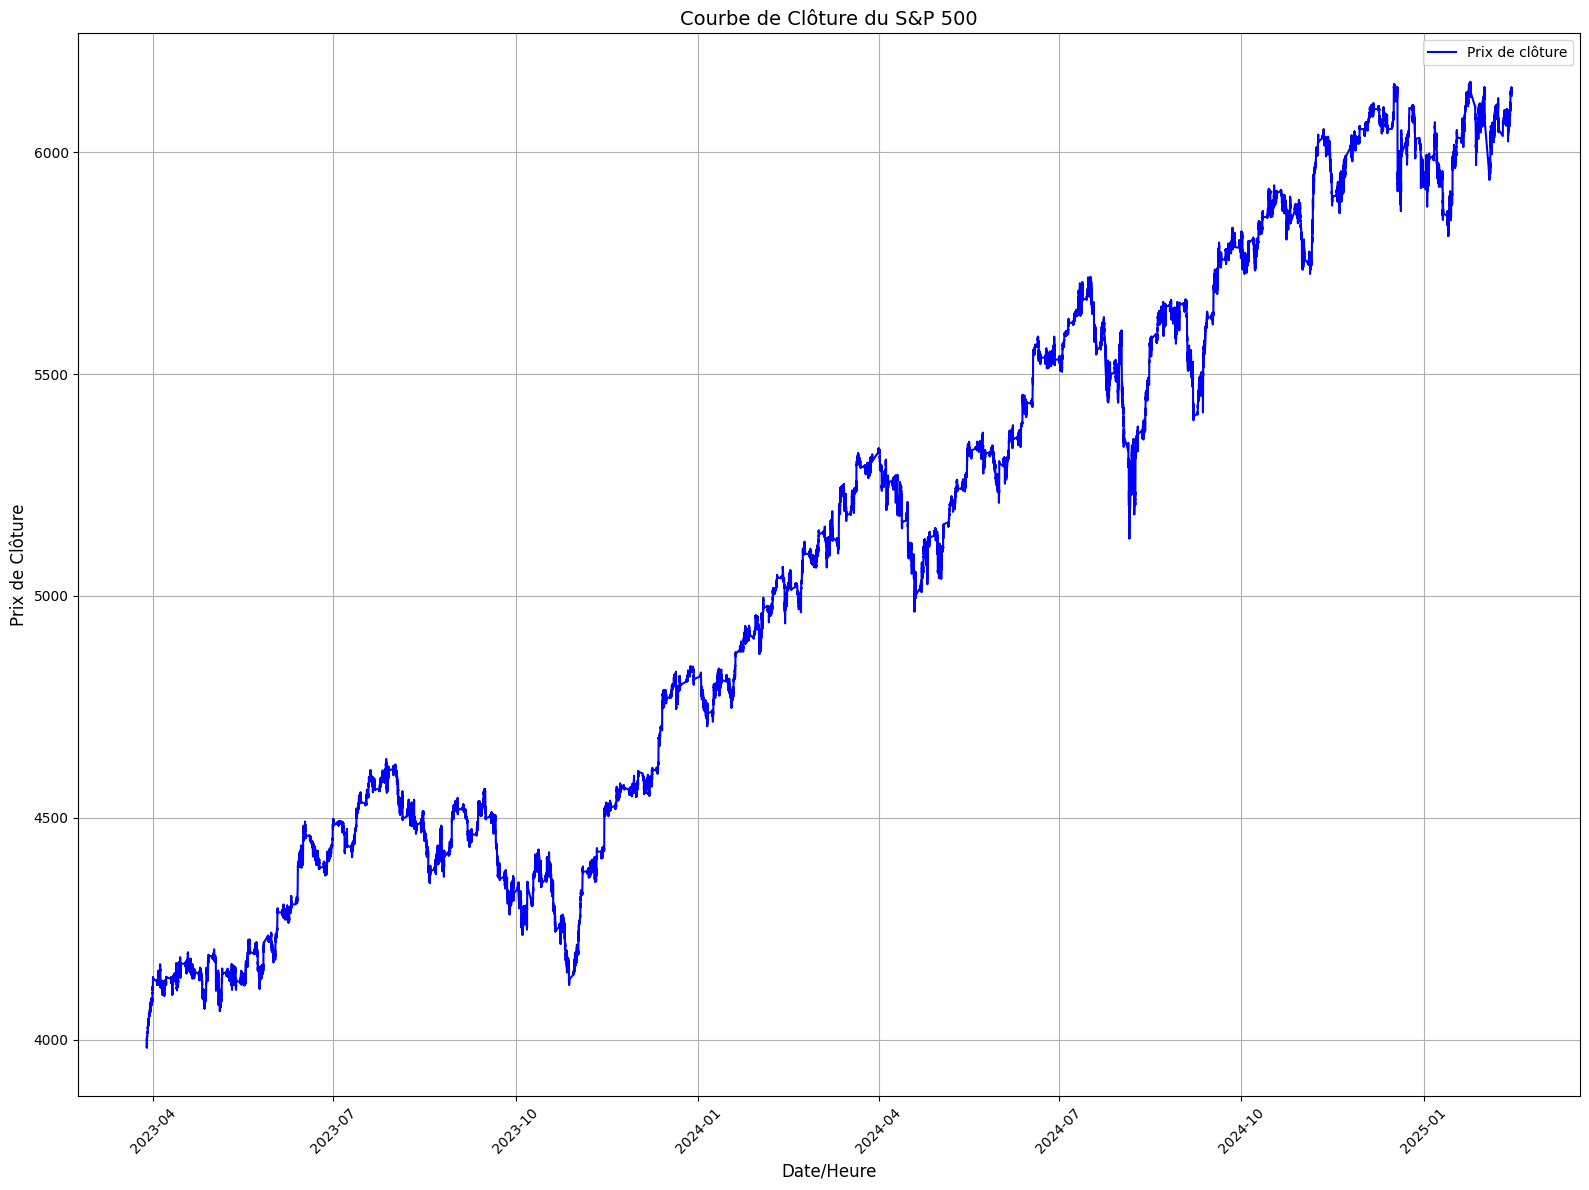

In [13]:
plt.figure(figsize=(16,12))
plt.plot(df_main['datetime'], df_main['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

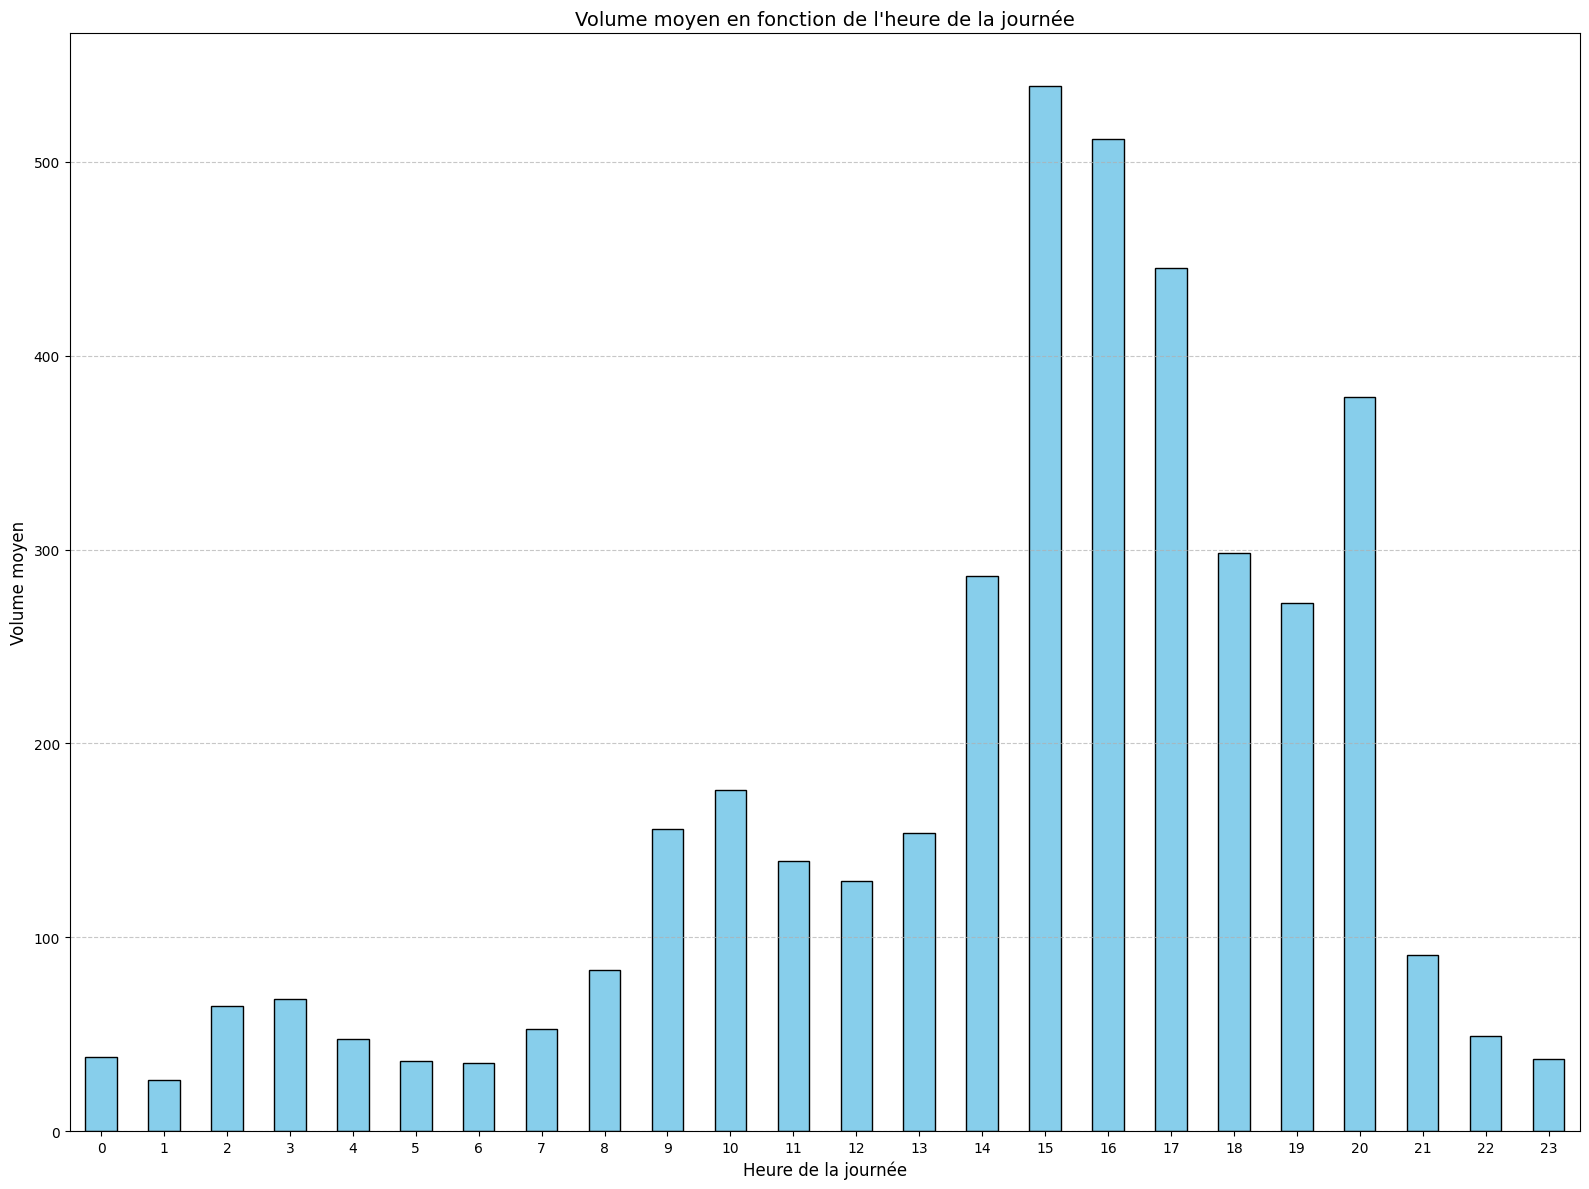

In [3]:

# Extraire l'heure de la journée à partir de 'timestamp'
df_main['hour'] = df_main['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_main.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(16, 12))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

In [1]:
from processing_functions import return_trade_datas_dataframe
name = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5']]_stopMethod=[1, 2]_TP=Variable_tickCrossed=[0, 2]_withCrossKijunExit=[True, False].pkl"
tradeDatasFormated = return_trade_datas_dataframe(name, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross
4,38.390,-31.80,-35.83,0.582,-0.398,2.13,"(539, 865, 14)",18.8,30,"(20, 40)",0 days 00:30:00,0 days 01:00:00,1,False,[5],0,True
68,37.245,-28.58,-32.64,0.595,-0.387,2.23,"(530, 893, 7)",17.9,30,"(20, 40)",0 days 00:30:00,0 days 01:00:00,2,False,[5],0,True
100,39.802,-24.68,-28.12,0.600,-0.434,1.95,"(482, 729, 2)",20.5,30,"(20, 40)",0 days 00:35:00,0 days 01:00:00,2,False,[5],2,True
36,40.852,-24.15,-27.58,0.592,-0.441,1.88,"(489, 708, 10)",21.3,30,"(20, 40)",0 days 00:35:00,0 days 01:05:00,1,False,[5],2,True
3,37.817,-24.27,-26.54,0.599,-0.411,2.02,"(298, 490, 9)",19.8,30,"(20, 40)",0 days 00:30:00,0 days 01:00:00,1,False,"[5, 15, 60]",0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,49.299,53.15,51.93,1.012,-0.745,1.65,"(211, 217, 0)",39.3,30,"(30, 70)",0 days 01:20:00,0 days 02:45:00,2,False,"[5, 15, 60]",2,False
32,47.543,57.92,55.61,0.968,-0.746,1.72,"(387, 427, 1)",37.8,30,"(30, 70)",0 days 01:25:00,0 days 02:50:00,1,False,[5],0,False
96,47.543,57.92,55.61,0.968,-0.746,1.72,"(387, 427, 1)",37.8,30,"(30, 70)",0 days 01:25:00,0 days 02:50:00,2,False,[5],0,False
31,50.522,64.28,62.91,0.990,-0.743,1.68,"(242, 237, 1)",38.7,30,"(30, 70)",0 days 01:30:00,0 days 02:50:00,1,False,"[5, 15, 60]",0,False


In [8]:
from processing_functions import describe_daily_and_weekly_trade_datas
describe_daily_and_weekly_trade_datas(name, selected_Id=9)

      profit_including_fees_from_start(%)
                                      sum
count                          686.000000
mean                             0.024659
std                              0.409905
min                             -2.158520
25%                              0.000000
50%                              0.000000
75%                              0.000000
max                              2.994320 
       profit_including_fees_from_start(%)
                                      sum
count                           99.000000
mean                             0.170869
std                              1.142146
min                             -2.911360
25%                             -0.554260
50%                              0.000000
75%                              0.744320
max                              4.532960


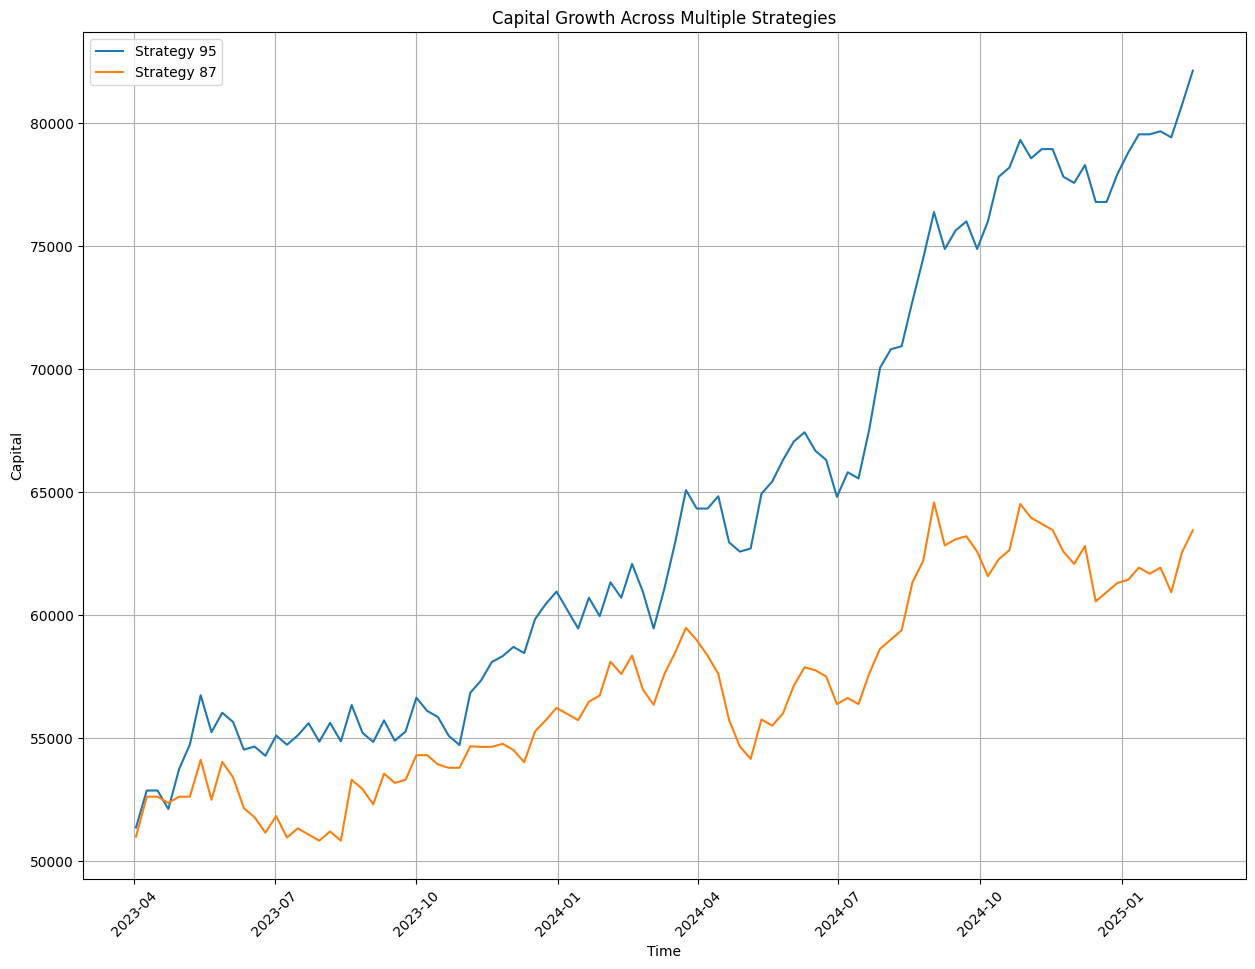

In [3]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name,
                             plotAllDatas=False, dataIdsSelected=[95, 87],
                             plotSize=(15,11))

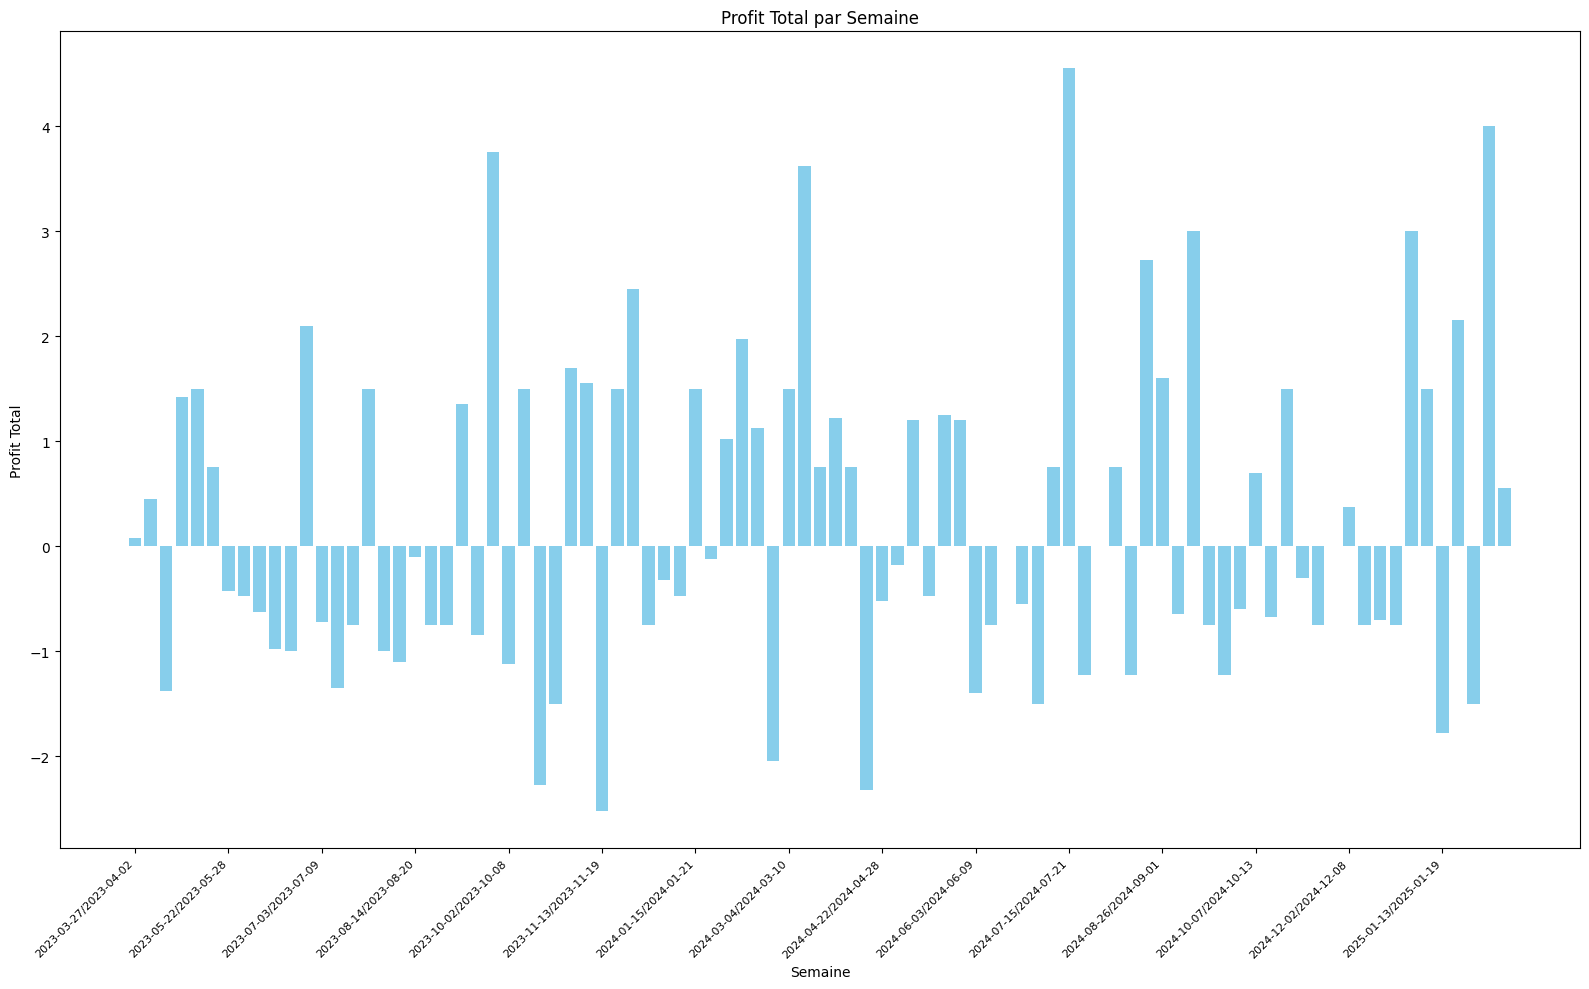

In [2]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name)

### TEST 2 : Utiliser les niveaux de prix généré avec les swings points ###

In [2]:
from processing_functions import return_trade_datas_dataframe
name = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5']]_"\
    "stopMethod=[1, 2]_TP=Variable_tickCrossed=[0, 2]_withCrossKijunExit=[False]_windowForLevels=[6, 12]_"\
    "nbr_of_points=[2, 3]_delta_in_ticks=[5].pkl"
tradeDatasFormated = return_trade_datas_dataframe(name, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross,nbr_of_points,delta_in_ticks,windowForLevels
66,39.655,4.75,4.59,1.321,-0.737,1.76,"(23, 35, 0)",39.9,30,"(30, 80)",0 days 00:55:00,0 days 02:35:00,1,True,[5],2,False,6,3,5
90,39.655,4.75,4.59,1.321,-0.737,1.76,"(23, 35, 0)",39.9,30,"(30, 80)",0 days 00:55:00,0 days 02:35:00,2,True,[5],2,False,6,3,5
70,40.816,5.25,5.11,1.320,-0.734,1.82,"(20, 29, 0)",41.3,30,"(30, 90)",0 days 01:10:00,0 days 02:45:00,1,True,[5],2,False,6,3,5
94,40.816,5.25,5.11,1.320,-0.734,1.82,"(20, 29, 0)",41.3,30,"(30, 90)",0 days 01:10:00,0 days 02:45:00,2,True,[5],2,False,6,3,5
54,42.424,7.75,7.56,1.272,-0.738,1.77,"(28, 38, 0)",39.7,30,"(30, 80)",0 days 00:55:00,0 days 02:35:00,1,True,[5],0,False,6,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,48.684,55.38,54.51,1.142,-0.734,1.85,"(148, 156, 0)",40.6,30,"(30, 90)",0 days 01:00:00,0 days 02:16:15,2,False,[5],0,False,12,2,5
104,48.773,56.82,55.90,1.126,-0.738,1.73,"(159, 167, 0)",40.4,30,"(30, 80)",0 days 00:55:00,0 days 02:15:00,1,False,[5],0,False,12,2,5
128,48.773,56.82,55.90,1.126,-0.738,1.73,"(159, 167, 0)",40.4,30,"(30, 80)",0 days 00:55:00,0 days 02:15:00,2,False,[5],0,False,12,2,5
100,49.704,62.18,61.22,1.113,-0.740,1.61,"(168, 170, 0)",40.3,30,"(30, 70)",0 days 00:55:00,0 days 01:58:45,1,False,[5],0,False,12,2,5


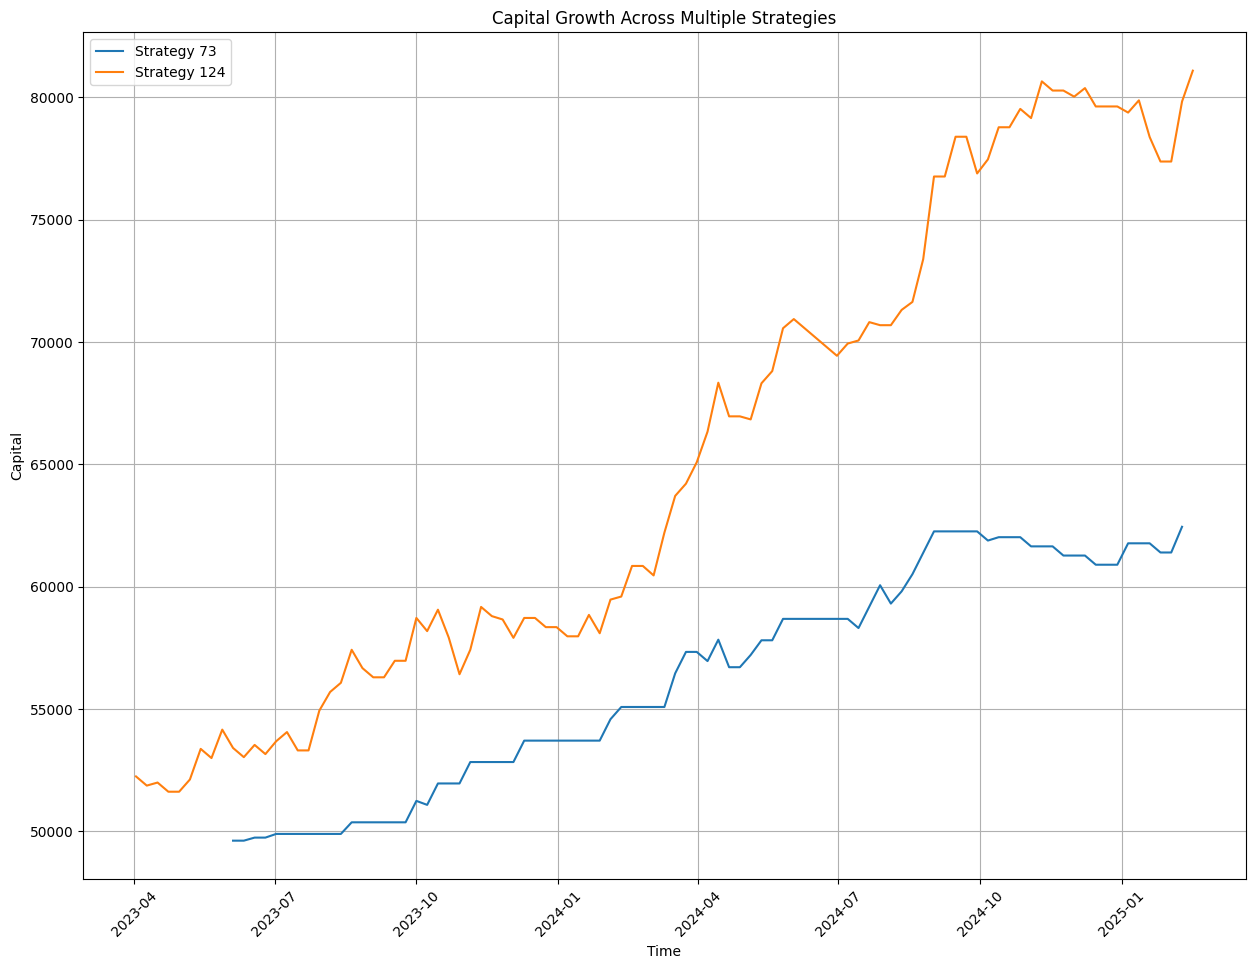

In [4]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name,
                             plotAllDatas=False, dataIdsSelected=[73,124],
                             plotSize=(15,11))

In [3]:
from processing_functions import get_winrate_by_short_and_long_position
get_winrate_by_short_and_long_position(name)

winrate short: 0.34285714285714286, winrate long: 0.40625


### TEST 3 : Utiliser le chop index pour prendre position ###

In [2]:
from processing_functions import return_trade_datas_dataframe
name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5', '15'], ['5']]_"\
    "stopMethod=[2]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False]chopValueToCross=[70, 61.8, 57, 50].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v1, sort_option=2)


ValueError: not enough values to unpack (expected 10, got 9)

In [7]:
from processing_functions import return_trade_datas_dataframe

name_v2 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '60'], ['5', '15'], ['5']]_"\
    "stopMethod=[2]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False]chopValueToCross=[61.8]_chopPeriod=[14, 28, 48].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v2, sort_option=2)
tradeDatasFormated.tail(20)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross,chopValue,chopPeriod
28,52.047,26.62,26.14,0.987,-0.744,1.70,"(89, 82, 1)",38.3,30,"(30, 70)",0 days 01:22:30,0 days 02:56:15,2,False,"[5, 60]",1,False,61.8,14
18,59.316,28.28,27.53,1.015,-1.211,1.07,"(156, 107, 1)",60.6,50,"(30, 70)",0 days 02:10:00,0 days 04:05:00,2,False,[5],0,False,61.8,14
41,60.476,30.25,29.65,1.026,-1.199,1.08,"(127, 83, 1)",59.9,50,"(30, 70)",0 days 02:10:00,0 days 03:50:00,2,False,"[5, 15]",1,False,61.8,14
34,52.761,30.38,29.91,1.022,-0.743,1.98,"(86, 77, 1)",37.8,30,"(30, 90)",0 days 01:35:00,0 days 03:10:00,2,False,"[5, 60]",1,False,61.8,14
4,53.073,30.65,30.14,0.983,-0.744,1.71,"(95, 84, 1)",38.1,30,"(30, 70)",0 days 01:27:30,0 days 02:55:00,2,False,"[5, 60]",0,False,61.8,14
29,52.358,30.88,30.27,0.958,-0.745,1.71,"(111, 101, 1)",37.9,30,"(30, 70)",0 days 01:30:00,0 days 02:55:00,2,False,"[5, 15]",1,False,61.8,14
35,52.451,31.65,31.07,0.973,-0.745,1.98,"(107, 97, 1)",37.9,30,"(30, 90)",0 days 01:35:00,0 days 03:10:00,2,False,"[5, 15]",1,False,61.8,14
22,60.714,31.72,31.25,1.087,-1.189,1.31,"(102, 66, 1)",57.1,50,"(30, 90)",0 days 02:20:00,0 days 04:15:00,2,False,"[5, 60]",0,False,61.8,14
47,60.396,34.70,34.12,1.076,-1.200,1.25,"(122, 80, 1)",60.2,50,"(30, 90)",0 days 02:20:00,0 days 04:10:00,2,False,"[5, 15]",1,False,61.8,14
30,51.154,34.90,34.16,0.976,-0.747,1.71,"(133, 127, 1)",38.0,30,"(30, 70)",0 days 01:30:00,0 days 03:00:00,2,False,[5],1,False,61.8,14


### TEST 4 : utiliser la sortie par cassure de kijun seulement si on est en profit ###

In [19]:
from processing_functions import return_trade_datas_dataframe
name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5', '60'], ['5', '15'], ['5']]_"\
    "stopMethod=[2, 3]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False, True].pkl"

name_v2 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 15], [5, 15, 60], [5, 60], [5, 15], [5]]_"\
    "stopMethod=[2, 3]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False, True].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v2, sort_option=2)
tradeDatasFormated.tail(20)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross
82,40.441,65.90,63.97,0.970,-0.500,2.36,"(275, 405, 0)",27.6,20,"(30, 70)",0 days 01:00:00,0 days 02:10:00,3,False,"[5, 60]",1,False
72,47.519,67.03,64.05,0.684,-0.503,2.38,"(498, 550, 0)",27.3,20,"(30, 70)",0 days 01:00:00,0 days 01:56:15,3,False,[5],0,True
71,47.877,66.82,64.15,0.690,-0.503,2.35,"(451, 491, 0)",27.6,20,"(30, 70)",0 days 01:00:00,0 days 01:55:00,3,False,"[5, 15]",0,True
67,60.163,75.22,65.49,0.365,-0.503,2.75,"(2063, 1366, 0)",23.7,20,"(30, 70)",0 days 00:31:00,0 days 00:51:00,3,False,[1],0,True
35,39.663,68.35,65.98,0.961,-0.499,2.35,"(330, 502, 1)",27.7,20,"(30, 70)",0 days 01:00:00,0 days 02:10:00,2,False,"[5, 15]",1,False
83,39.663,68.35,65.98,0.961,-0.499,2.35,"(330, 502, 1)",27.7,20,"(30, 70)",0 days 01:00:00,0 days 02:10:00,3,False,"[5, 15]",1,False
48,43.691,68.82,66.10,0.805,-0.501,2.39,"(419, 540, 1)",27.1,20,"(30, 70)",0 days 01:00:00,0 days 02:10:00,2,False,[5],1,True
45,45.955,68.12,66.47,0.839,-0.501,2.29,"(267, 314, 0)",28.4,20,"(30, 70)",0 days 01:00:00,0 days 02:05:00,2,False,"[5, 15, 60]",1,True
12,38.769,70.05,67.28,0.969,-0.500,2.40,"(378, 597, 1)",27.1,20,"(30, 70)",0 days 01:00:00,0 days 02:15:00,2,False,[5],0,False
60,38.769,70.05,67.28,0.969,-0.500,2.40,"(378, 597, 1)",27.1,20,"(30, 70)",0 days 01:00:00,0 days 02:15:00,3,False,[5],0,False


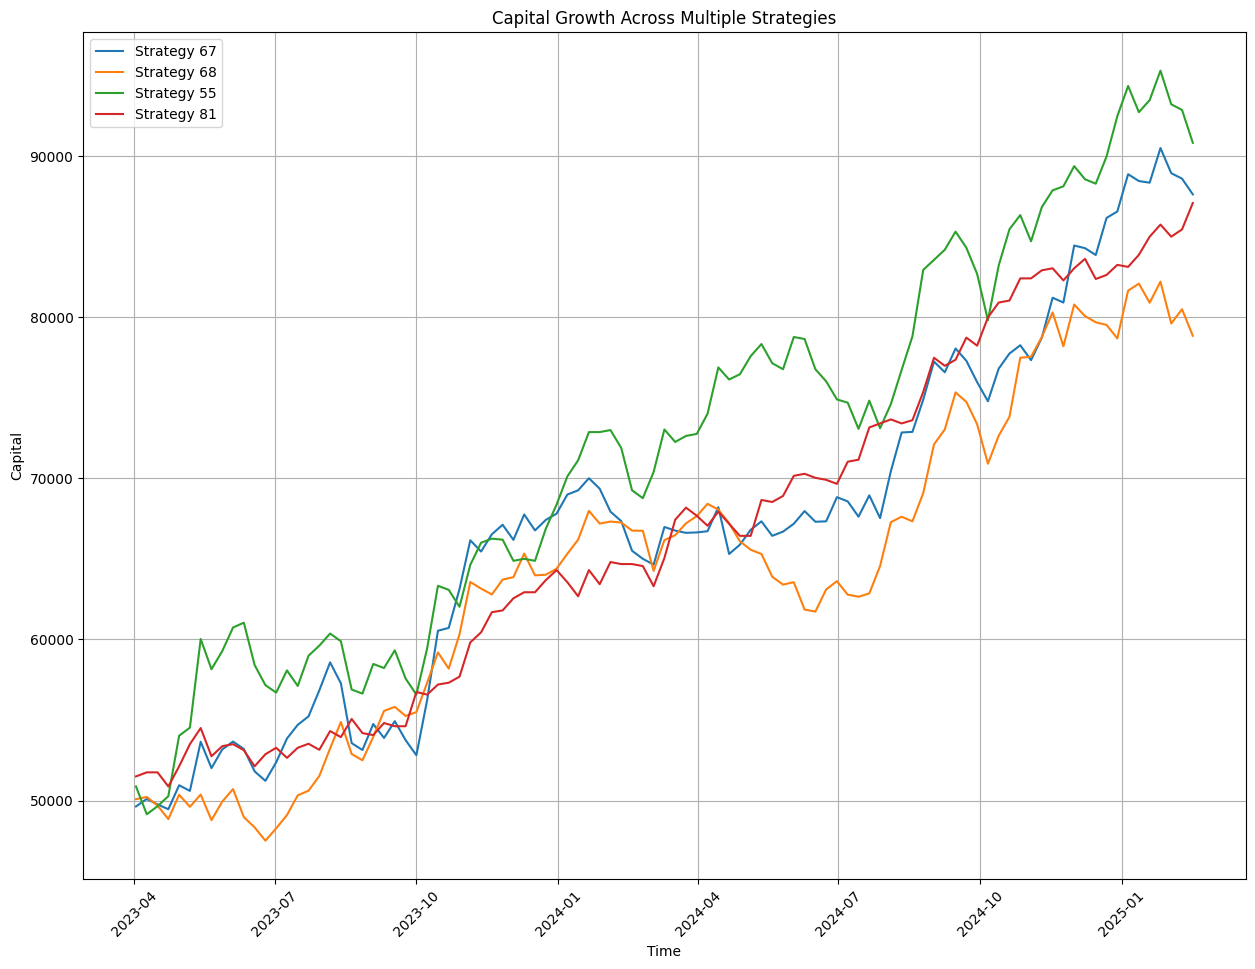

In [12]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name_v2,
                             plotAllDatas=False, dataIdsSelected=[67,68,55,81],
                             plotSize=(15,11))

In [18]:
from processing_functions import get_winrate_by_short_and_long_position
get_winrate_by_short_and_long_position(name_v2)

winrate short: 0.4006514657980456, winrate long: 0.3952380952380952


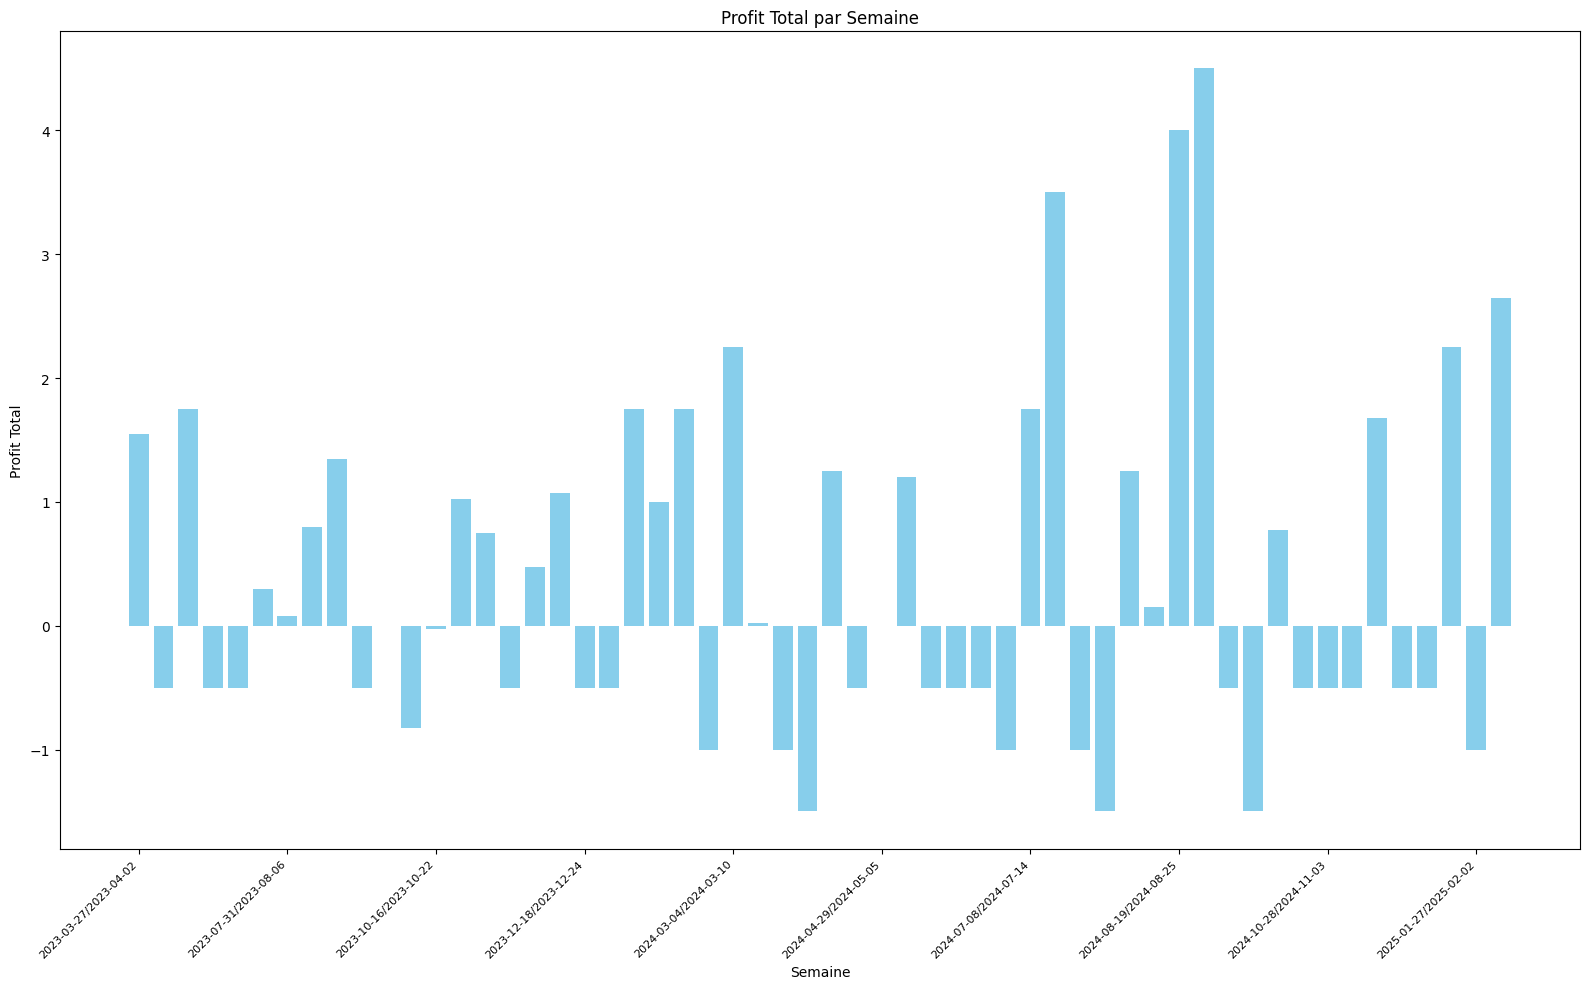

In [12]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name)

choses à faire pour continuer à backtest :
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 